In [56]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
import geopandas as gpd
import folium
import branca.colormap as cm
import libpysal
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point

from libpysal.weights import Queen, Rook, KNN
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
import seaborn as sns

from matplotlib.lines import Line2D
import copy
from pysankey import sankey
import plotly.graph_objects as go
plt.rcParams["font.family"] = "serif"
import matplotlib

font = {
    # 'family' : 'normal',
    # 'weight' : 'bold',
    'size'   : 16
}

In [57]:
ROOT = Path.cwd().parent.parent
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
OUT = ROOT / 'out'
ANALYSIS = ROOT / 'data' / 'analysis'

In [58]:
gdf = gpd.read_file(ANALYSIS / 'clusters4.geojson', driver='GeoJSON')
gdf.head()

,msoa,population,population_under_12,area,road_pct,population_density,rural_urban_category,primary,school_capacity,pca_1,...,cluster_km_1,cluster_name_gmm,cluster_color_gmm,cluster_color_km_1,cluster_name_km_1,cluster_name_km_2,cluster_color_km_2,cluster_km_2,cluster_color_defra,geometry
0,E02000001,8579,466.0,2.8850,0.270328,2973.656846,Urban major conurbation,1.0,271.0,-5.160598,...,4,Urban 1,#a50026,#a51225,Urban 1 (Inner Central),Urban 1,#a51225,0,#a51225,"POLYGON ((-0.07615 51.51048, -0.07687 51.51047..."
1,E02000002,8281,1732.0,2.1616,0.108461,3830.958549,Urban major conurbation,1.0,694.0,0.155038,...,7,Urban 4 (Outer),#fdae61,#eaa15c,Urban 4 (Small town or periphery),Urban 4,#eaa15c,7,#a51225,"POLYGON ((0.13954 51.57959, 0.13971 51.57895, ..."
2,E02000003,11538,2082.0,2.1415,0.136432,5387.812281,Urban major conurbation,2.0,1084.0,-1.043485,...,2,Urban 3 (Suburban),#f46d43,#dc783e,Urban 3 (Suburban),Urban 3,#dc783e,5,#a51225,"POLYGON ((0.12976 51.56890, 0.13008 51.56936, ..."
3,E02000004,6646,995.0,2.4929,0.070085,2665.971359,Urban major conurbation,1.0,840.0,0.085328,...,7,Urban 4 (Outer),#fdae61,#eaa15c,Urban 4 (Small town or periphery),Urban 4,#eaa15c,7,#a51225,"POLYGON ((0.18505 51.55682, 0.18477 51.55643, ..."
4,E02000005,11091,2329.0,1.1881,0.185351,9335.072805,Urban major conurbation,2.0,1416.0,-2.223478,...,5,Urban 2,#d73027,#c54b2c,Urban 2 (Outer Central),Urban 2,#c54b2c,3,#a51225,"POLYGON ((0.14785 51.55735, 0.14833 51.55673, ..."


In [59]:
# Rename Categories for better visualization

defra_map = {
    "Urban major conurbation": "Urban (Major)",
    'Urban minor conurbation': "Urban (Minor)",
    'Urban city and town': "Urban (Small)",
    'Urban city and town in a sparse setting': "Urban (Small, sparse)",
    'Rural town and fringe': "Rural (Town)",
    'Rural town and fringe in a sparse setting': "Rural (Town, sparse)",
    'Rural village and dispersed': "Rural (Village)",
    'Rural village and dispersed in a sparse setting': "Rural (Village, sparse)"}
km_map = {
    'Urban 1 (Inner Central)':'Urban 1', 
    'Urban 2 (Outer Central)': 'Urban 2', 
    'Urban 3 (Suburban)': "Urban 3", 
    'Urban 4 (Small town or periphery)': "Urban 4",
    'Urban 5 (Remote)': "Urban 5", 
    'Rural 1 (Connected)': 'Rural 1', 
    'Rural 2':  'Rural 2', 
    'Rural 3 (Remote)': 'Rural 3',
}
gdf['rural_urban_category'] = gdf['rural_urban_category'].replace(defra_map)
gdf['cluster_name_km_1'] = gdf['cluster_name_km_1'].replace(km_map)

# England-wide map comparison

In [60]:

order_km = list(km_map.values())
order_km2 = ["Urban 1", "Urban 2", "Urban 3", "Urban 4", "Urban 5","Urban 6", "Rural 1", "Rural 2", "Rural 3", "Rural 4"]
order_defra = list(defra_map.values())

palette_km = gdf[['cluster_name_km_1', 'cluster_color_km_1']].drop_duplicates().set_index('cluster_name_km_1').to_dict()['cluster_color_km_1']
palette_km = {k: palette_km[k] for k in order_km}

palette_km2 = gdf[['cluster_name_km_2', 'cluster_color_km_2']].drop_duplicates().set_index('cluster_name_km_2').to_dict()['cluster_color_km_2']
palette_km2 = {k: palette_km2[k] for k in order_km2}

palette_defra = gdf[['rural_urban_category', 'cluster_color_defra']].drop_duplicates().set_index('rural_urban_category').to_dict()['cluster_color_defra']
palette_defra = {k: palette_defra[k] for k in order_defra}


(49.7, 55.8)

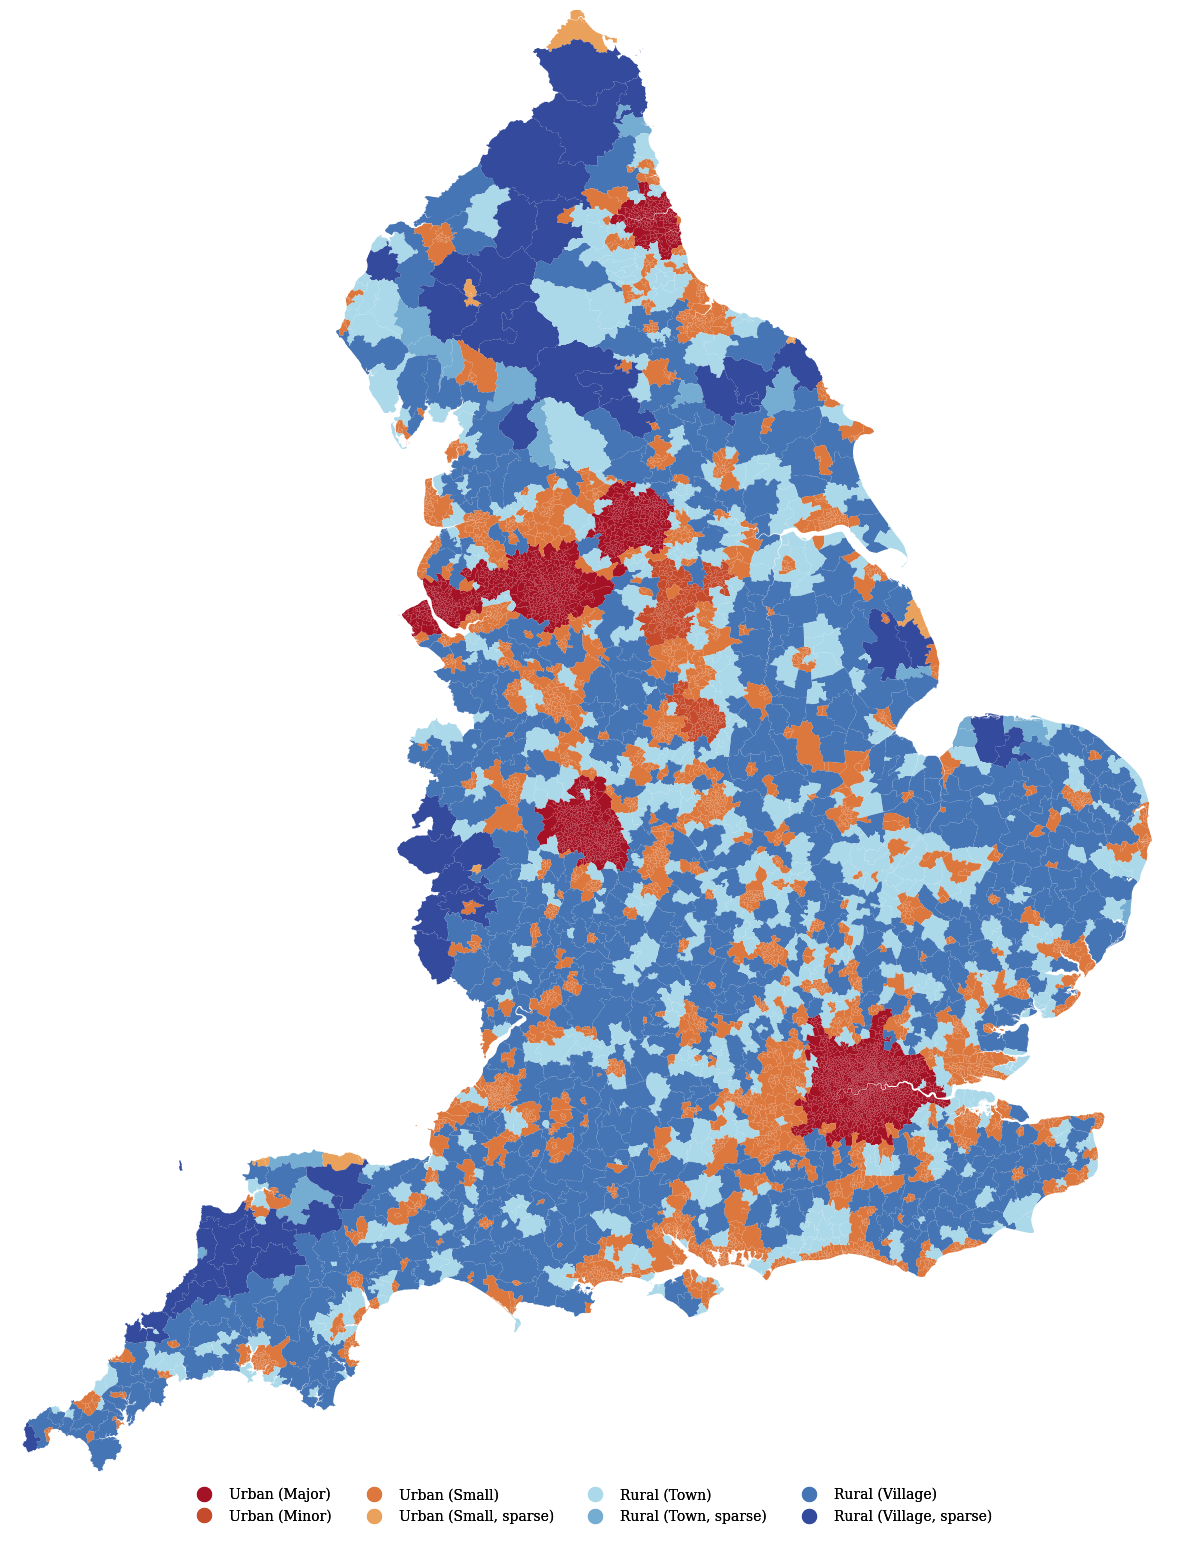

In [62]:
fig, ax = plt.subplots(1, figsize=(15, 20))
gdf.plot(
    color=gdf['cluster_color_defra'],
    # color=gdf['cluster_color_defra'],
    # cmap=cmap,
    ax=ax,
    legend=True,
    # edgecolor='white',
    # linewidth=0.05
)

custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in palette_defra.values()]
leg_points_defra = ax.legend(custom_points, palette_defra.keys(), loc='lower center', ncols=4,
                          frameon=False)    
ax.add_artist(leg_points_defra)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.set_axis_off()
ax.set_xlim(-5.8, 1.9)
ax.set_ylim(49.7, 55.8)
# plt.savefig(OUT / "cluster_england_DEFRA.png", format="png", bbox_inches='tight', dpi=500)

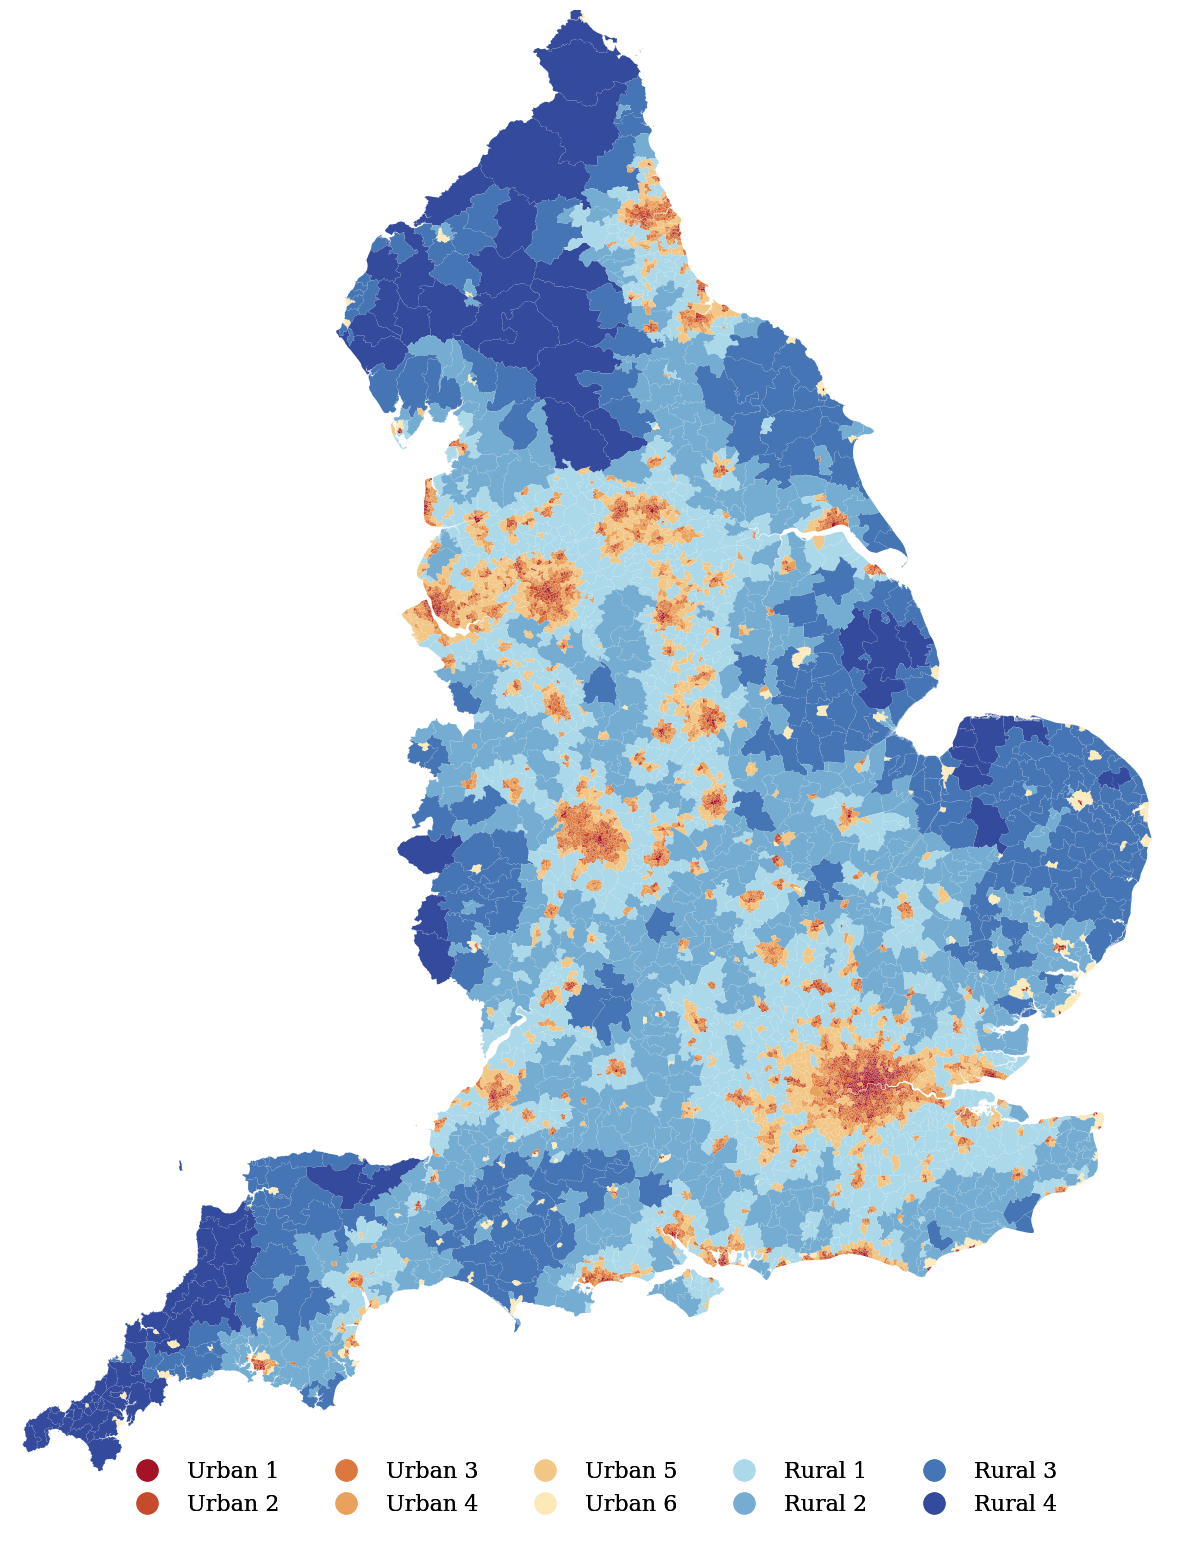

In [63]:
fig, ax = plt.subplots(1, figsize=(15, 20))
ncols = 5
km1or2 = 2
gdf.plot(
    # legend=True,
    color=gdf[f'cluster_color_km_{km1or2}'],
    ax=ax,
    # palette=palette_km,
    categorical=True,
    legend=True,
    edgecolor='white',
    linewidth=0.025
)

# Add manual legend - this is a horrible workaround
p = palette_km if km1or2 == 1 else palette_km2
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=15, color=color) for color in p.values()]
leg_points_km = ax.legend(custom_points, p.keys(), loc='lower center', ncols=ncols,
                          frameon=False, fontsize=16)    
ax.add_artist(leg_points_km)
ax.set_axis_off()
ax.set_xlim(-5.8, 1.9)
ax.set_ylim(49.7, 55.8)
plt.savefig(OUT / "cluster_england.png", format="png", bbox_inches='tight', dpi=1000)

# Notts

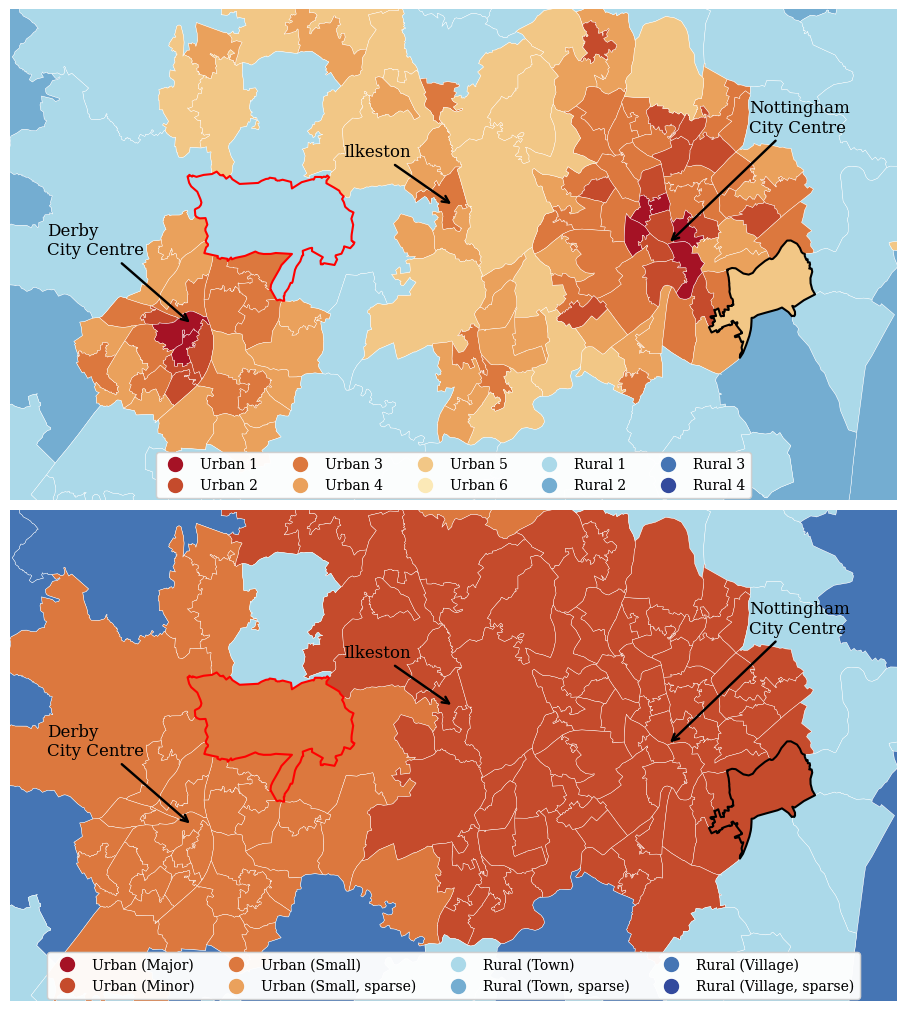

In [64]:
#TODO: Maybe Newcastle would be better because it has more extreme rural close to it?
# i.e. it has every classification in that small area...

fig_sw, ax = plt.subplots(2, figsize=(10, 10), constrained_layout=True)
# fig_small, ax = plt.subplots(1, 2, figsize=(10, 10), constrained_layout=True)
sw_ylim = (52.85, 53.05)
sw_xlim = (-1.6, -1)
fs = 10
ncols=5
gdf.plot(
    # legend=True,
    color=gdf[f'cluster_color_km_{km1or2}'],
    ax=ax[0],
    # palette=palette_km,
    categorical=True,
    legend=True,
    edgecolor='white',
    linewidth=0.3
)

# Add manual legend - this is a horrible workaround
p = palette_km if km1or2 == 1 else palette_km2
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in p.values()]
leg_points_km = ax[0].legend(custom_points, p.keys(), loc='lower center', ncols=ncols,
                          frameon=True, bbox_to_anchor=(0.5, -0.01), fontsize=fs)    
ax[0].add_artist(leg_points_km)

gdf.plot(
    color=gdf['cluster_color_defra'],
    # color=gdf['cluster_color_defra'],
    # cmap=cmap,
    ax=ax[1],
    legend=True,
    edgecolor='white',
    linewidth=0.3
)

custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in palette_defra.values()]
leg_points_defra = ax[1].legend(
    custom_points, palette_defra.keys(), 
    loc='lower center', ncols=4,
    frameon=True, bbox_to_anchor=(0.5, -0.01), fontsize=fs)    
ax[1].add_artist(leg_points_defra)

dale_abbey = (-1.3512062234861715, 52.94559444257148 )
locko_park = (-1.3951459826401584, 52.94031294259522 )
west_hallam = ( -1.3606437629663648, 52.97086564185855)
ilkeston = (-1.30, 52.97)
arrowprops = dict(facecolor='black',  arrowstyle='->', linewidth=1.75)
arrowprops2 = dict(facecolor='white',  arrowstyle='->', linewidth=1.75)
for i in [0, 1]:
    ax[i].set_axis_off()
    ax[i].set_ylim(*sw_ylim)
    ax[i].set_xlim(*sw_xlim)
    ax[i].annotate("Nottingham\nCity Centre", style='normal', xy=(-1.1549, 52.9545), fontsize=12, color='black', xytext=(-1.1, 53), arrowprops=arrowprops)
    ax[i].annotate("Derby\nCity Centre", xy=(-1.4769, 52.9216), fontsize=12, color='black', arrowprops=arrowprops, xytext=(-1.575, 52.95))
    ax[i].annotate("Ilkeston", xy=ilkeston, fontsize=12, color='black', arrowprops=arrowprops, xytext=(-1.375, 52.99))
    # ax[i].annotate("Dale Abbey", style='italic', xy=dale_abbey, fontsize=12, color='black' , xytext=(-1.47, 52.96), arrowprops=arrowprops2)
    # ax[i].annotate("Locko Park", style='italic', xy=locko_park, fontsize=12, color='black', xytext=(-1.4, 52.88), arrowprops=arrowprops2)
    # ax[i].annotate("West Hallam", style='italic', xy=west_hallam, fontsize=12, color='black', xytext=(-1.4, 52.99), arrowprops=arrowprops2)
# plt.savefig(OUT / "cluster_notts.png", format="png", bbox_inches='tight', dpi=1000)
    # gdf[gdf['msoa'] == 'E02006906'].geometry.boundary.plot(ax=ax[i], edgecolor='black', linewidth=1.5)
    # gdf[gdf['msoa'] == 'E02004082'].geometry.boundary.plot(ax=ax[i], edgecolor='red', linewidth=1.5)
    gdf[gdf['msoa'] == 'E02005911'].geometry.boundary.plot(ax=ax[i], edgecolor='black', linewidth=1.5)
    gdf[gdf['msoa'] == 'E02004081'].geometry.boundary.plot(ax=ax[i], edgecolor='red', linewidth=1.5)

# plt.savefig(OUT / "cluster_notts.png", format="png", bbox_inches='tight', dpi=1000)

<Axes: >

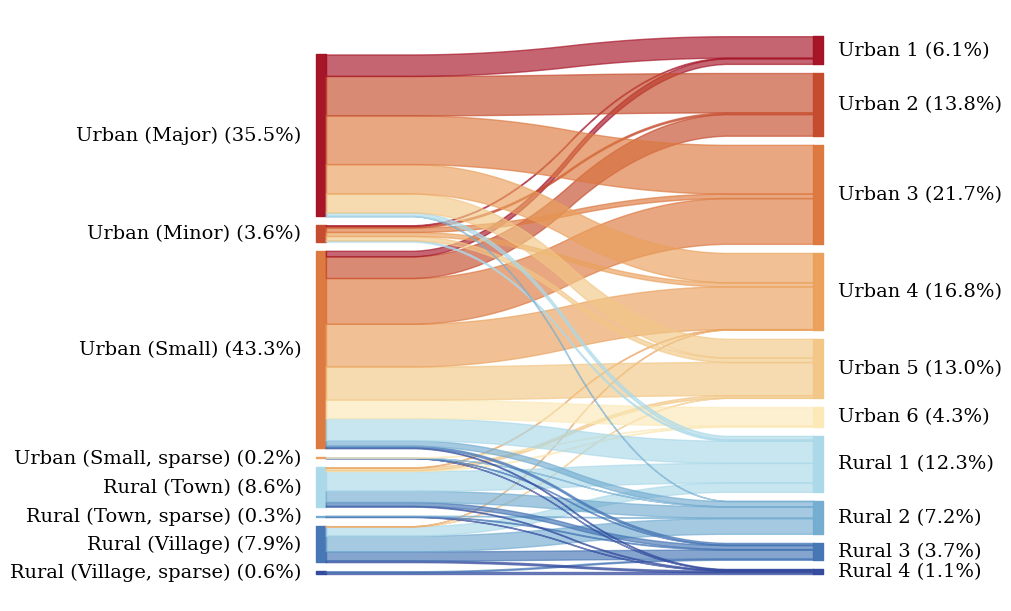

In [65]:
# Do the same for the whole dataset - try and add labels

# get percentages of each category rural_urban_category and cluster_name_km_2
props_defra = gdf.rural_urban_category.value_counts(normalize=True).to_dict()
props_km2 = gdf.cluster_name_km_2.value_counts(normalize=True).to_dict()

order_defra_sankey = list(reversed(order_defra))
order_defra_sankey = [item + " ("+ str(round(props_defra[item]*100,1)) + "%)" for item in order_defra_sankey]
order_km2_sankey = list(reversed(order_km2))
order_km2_sankey = [item + " ("+ str(round(props_km2[item]*100,1)) + "%)" for item in order_km2_sankey]

gdf_sankey = gdf.copy()
gdf_sankey['rural_urban_category'] = gdf_sankey['rural_urban_category'] + " (" + (gdf_sankey['rural_urban_category'].map(props_defra)*100).round(1).astype(str) +  "%)"
gdf_sankey['cluster_name_km_2'] = gdf_sankey['cluster_name_km_2'] + " (" + (gdf_sankey['cluster_name_km_2'].map(props_km2)*100).round(1).astype(str) + "%)"

palette_defra_sankey = {k + " ("+ str(round(props_defra[k]*100,1)) + "%)" :palette_defra[k] for k,v in props_defra.items()}
# palette_defra_sankey = {k + " ("+ str(round(props_defra[k]*100,1)) + "%)" :'' for k,v in props_defra.items()}
palette_km2_sankey = {k + " ("+ str(round(props_km2[k]*100,1)) + "%)" :palette_km2[k] for k,v in props_km2.items()}

fig, ax = plt.subplots(1, figsize=(10, 6), constrained_layout=True)
sankey(
    gdf_sankey['rural_urban_category'],
    gdf_sankey['cluster_name_km_2'],
    colorDict={**palette_defra_sankey, **palette_km2_sankey},
    leftLabels=order_defra_sankey,
    rightLabels=order_km2_sankey,
    ax=ax,
    rightColor=True
    
)
# fig.savefig(OUT / "sankey_all.png", format="png", bbox_inches='tight', dpi=100)


# Compare K-Means and GMM Case Study

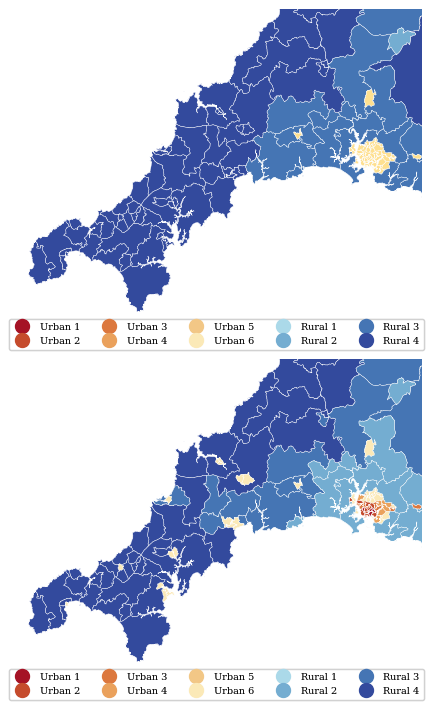

In [66]:


fig, ax = plt.subplots(2, 1, figsize=(15, 7), constrained_layout=True)
gdf.plot(
    color=gdf['cluster_color_gmm'],
    ax=ax[0],
    edgecolor='white',
    linewidth=0.3
    
)
gdf.plot(
    color=gdf['cluster_color_km_2'],
    ax=ax[1],
    edgecolor='white',
    linewidth=0.3
)

for i in [0, 1]:
    ax[i].set_xlim(-5.8, -3.9)
    ax[i].set_ylim(49.85, 50.8)
    ax[i].axis('off')

for i in [0, 1]:
# Add manual legend - this is a horrible workaround
    p = palette_km if km1or2 == 1 else palette_km2
    custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=10, color=color) for color in p.values()]
    leg_points_km = ax[i].legend(custom_points, p.keys(), loc='lower center', ncols=ncols,
                            frameon=True, bbox_to_anchor=(0.5, -0.01), fontsize=7)    
    ax[i].add_artist(leg_points_km)

plt.savefig(OUT / "kmeans_v_gmm2.png", format="png", bbox_inches='tight', dpi=500)


# Green belt intersection

In [68]:
p_greenbelt = "/Users/toby/Dev/connectivity-analysis/data/raw/England_Green_Belt_2022_23_WGS84"
gdf_green = gpd.read_file(p_greenbelt)
# gdf_green.plot()
gdf_rushcliffe = gdf_green[gdf_green['LAD_NM'] == 'Rushcliffe']
gdf_example = gdf[gdf['msoa'] == 'E02005911']
f = gdf_example.explore(
    color='cluster_color_km_2', 
    tiles='cartodbpositron', 
    style_kwds={"weight":3, "fillOpacity": 0, 'color':'black'}, 
    highlight=False,
    tooltip=False,
    # cmap=lambda value: palette_km2[value],
)
shapes = gdf_green.geometry.values

for sh in shapes:
    folium_shape = folium.GeoJson(sh.__geo_interface__, name='Rushcliffe Greenbelt', 
                                  style_function=lambda x: {
                                      'color': 'green', 'fillColor': 'green', 'weight': 0.25, 'fillOpacity': 0.5
                                    })
    f.add_child(folium_shape)


# create a folium layer from the shape
# folium_shape = folium.GeoJson(shape.__geo_interface__, name='Rushcliffe Greenbelt', 
#                               style_function=lambda x: {
#                                   'color': 'green', 'fillColor': 'green', 'weight': 0.25, 'fillOpacity': 0.5
#                                 })

# # add the greenbelt to the figure
# f.add_child(folium_shape)
# f|

In [69]:
gdf_erewash = gdf_green[gdf_green['LAD_NM'] == 'Erewash']
gdf_example = gdf[gdf['msoa'] == 'E02004081']
f = gdf_example.explore(
    color='cluster_color_km_2', 
    tiles='cartodbpositron', 
    style_kwds={"weight":3, "fillOpacity": 0, 'color':'red'}, 
    highlight=False,
    tooltip=False,
    # cmap=lambda value: palette_km2[value],
)
shapes = gdf_green.geometry.values

for sh in shapes:
    folium_shape = folium.GeoJson(sh.__geo_interface__, name='Rushcliffe Greenbelt', 
                                  style_function=lambda x: {
                                      'color': 'green', 'fillColor': 'green', 'weight': 0.25, 'fillOpacity': 0.5
                                    })
    f.add_child(folium_shape)


# add the greenbelt to the figure
# f.add_child(folium_shape)
# f

# Model Performance

## ARI

In [225]:
# https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
from sklearn import metrics

In [33]:
# Raw ARI
print(metrics.adjusted_rand_score(gdf['cluster_name_km_2'], gdf['rural_urban_category']))

# ARI with urban/rural only

print(gdf.cluster_name_km_2.str.contains('Urban').sum() / gdf.shape[0])
print(gdf.rural_urban_category.str.contains('Urban').sum() / gdf.shape[0])



0.09111203831672578
0.7566739606126914
0.825674690007294


In [34]:
urb_km2 = gdf.cluster_name_km_2.str.contains('Urban')
urb_defra = gdf.rural_urban_category.str.contains('Urban')

metrics.adjusted_rand_score(urb_km2, urb_defra)

0.6440954440366515

In [55]:
metrics.adjusted_rand_score(gdf['defra_urban'], gdf['gmm_urban'])

0.605140018025152

In [56]:
metrics.adjusted_rand_score(gdf['defra_urban'], gdf['km_urban'])

0.6082192431741881

In [57]:
print(metrics.adjusted_mutual_info_score(gdf['defra_urban'], gdf['gmm_urban']))
print(metrics.adjusted_mutual_info_score(gdf['defra_urban'], gdf['km_urban']))

0.48700352789061874
0.4939497115834026


# Compare GMM and K Means

In [223]:
gdf.columns


Index(['msoa', 'road_pct', 'population_density', 'rural_urban_category',
       'primary', 'school_capacity', 'pca_1', 'pca_2', 'cluster_gmm',
       'cluster_km_1', 'cluster_name_gmm', 'cluster_color_gmm',
       'cluster_color_km_1', 'cluster_name_km_1', 'cluster_name_km_2',
       'cluster_color_km_2', 'cluster_km_2', 'cluster_color_defra',
       'geometry'],
      dtype='object')

In [283]:
# Raw ARI
print(metrics.adjusted_rand_score(gdf['cluster_name_km_2'], gdf['cluster_gmm_2']))

# ARI with urban/rural only

# print(gdf.cluster_name_km_2.str.contains('Urban').sum() / gdf.shape[0])
# print(gdf.cluster_name_gmm.str.contains('Urban').sum() / gdf.shape[0])

# print(metrics.adjusted_rand_score(gdf['cluster_name_km_2'].str.contains('Urban'), gdf['cluster_gmm_2'].str.contains('Urban')))

0.8190736588291038
0.8721141043166145


# School capacity per rural urban

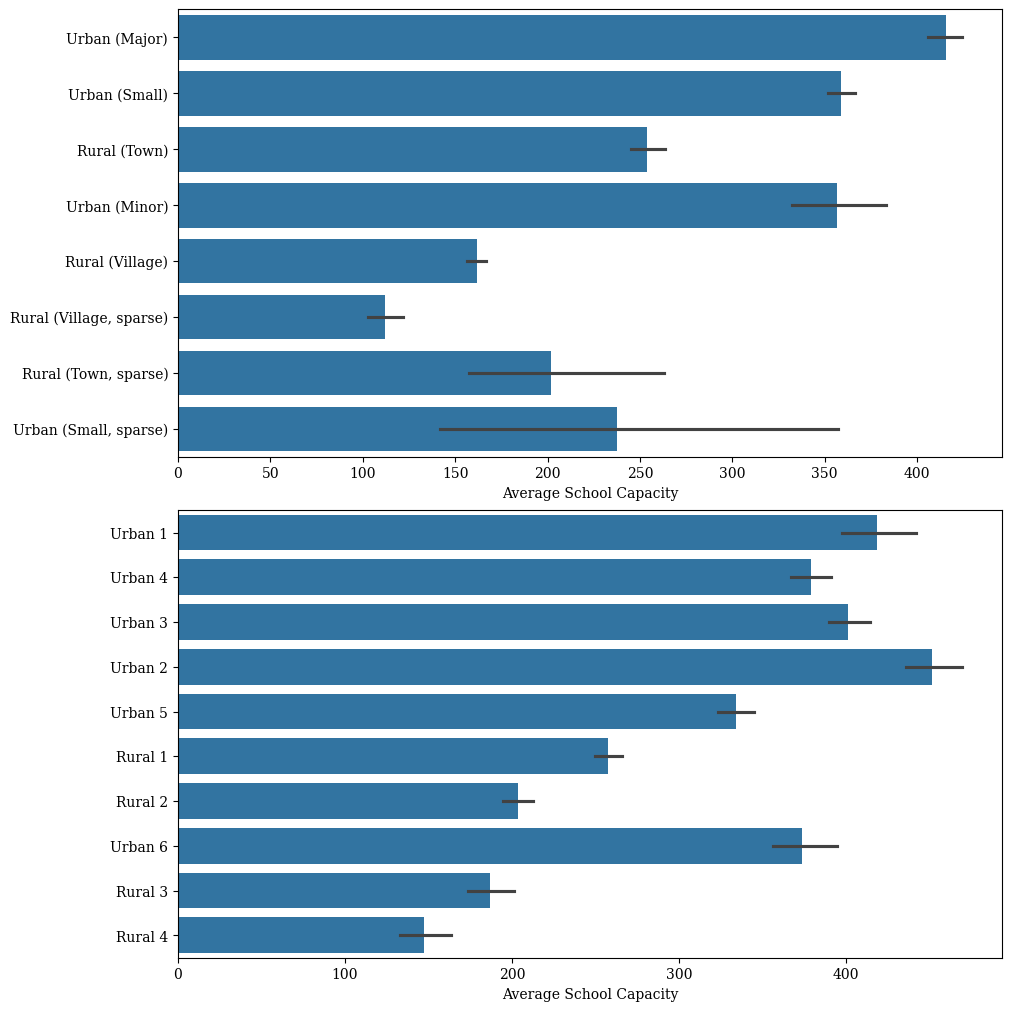

In [37]:
f, ax = plt.subplots(2, figsize=(10, 10), constrained_layout=True)

km_2_map = {
    0: "Urban 1",
    3: "Urban 2",
    5: "Urban 3",
    7: "Urban 4",
    1: "Urban 5",
    8: "Urban 6",
    2: "Rural 1",
    9: "Rural 2",
    4: "Rural 3",
    6: "Rural 4",
}
defra_map = {
    "Urban major conurbation": "Urban (Major)",
    'Urban minor conurbation': "Urban (Minor)",
    'Urban city and town': "Urban (Small)",
    'Urban city and town in a sparse setting': "Urban (Small, sparse)",
    'Rural town and fringe': "Rural (Town)",
    'Rural town and fringe in a sparse setting': "Rural (Town, sparse)",
    'Rural village and dispersed': "Rural (Village)",
    'Rural village and dispersed in a sparse setting': "Rural (Village, sparse)"}

gdf['avg_school_cap'] = gdf.school_capacity / gdf.primary
sns.barplot(y='rural_urban_category', x='avg_school_cap', data=gdf, ax=ax[0])
sns.barplot(y='cluster_name_km_2', x='avg_school_cap', data=gdf, ax=ax[1])
# plt.xticks(rotation=45)
ax[0].set_xlabel('Average School Capacity')
ax[1].set_xlabel('Average School Capacity')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.savefig(OUT / "school_capacity.png", format="png", bbox_inches='tight', dpi=500)

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Urban (Major)'),
  Text(1, 0, 'Urban (Small)'),
  Text(2, 0, 'Rural (Town)'),
  Text(3, 0, 'Urban (Minor)'),
  Text(4, 0, 'Rural (Village)'),
  Text(5, 0, 'Rural (Village, sparse)'),
  Text(6, 0, 'Rural (Town, sparse)'),
  Text(7, 0, 'Urban (Small, sparse)')])

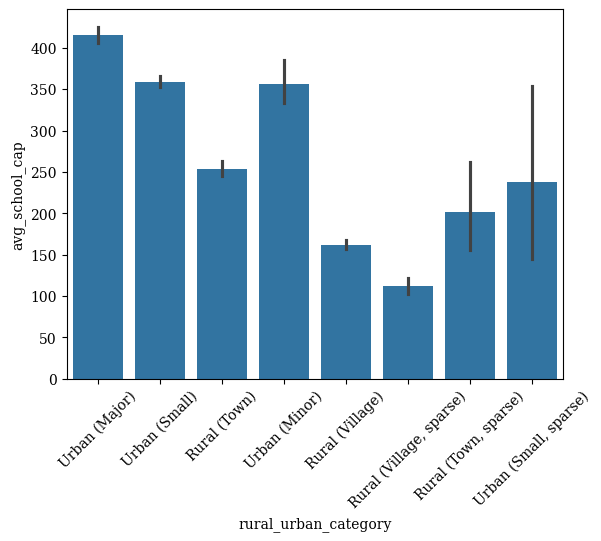

In [40]:
sns.barplot(x='rural_urban_category', y='avg_school_cap', data=gdf)
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Urban (Major)'),
  Text(1, 0, 'Urban (Small)'),
  Text(2, 0, 'Rural (Town)'),
  Text(3, 0, 'Urban (Minor)'),
  Text(4, 0, 'Rural (Village)'),
  Text(5, 0, 'Rural (Village, sparse)'),
  Text(6, 0, 'Rural (Town, sparse)'),
  Text(7, 0, 'Urban (Small, sparse)')])

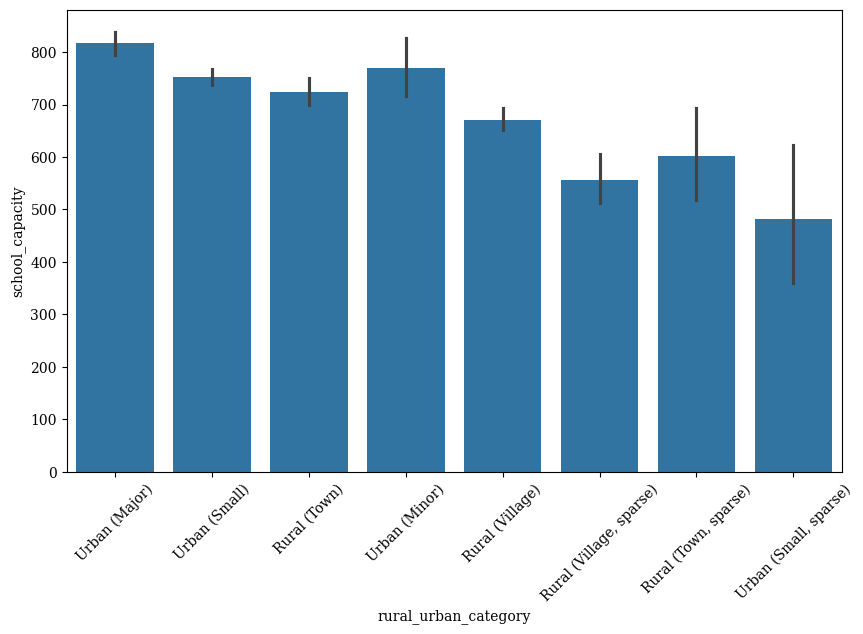

In [36]:
f, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(x='rural_urban_category', y='school_capacity', data=gdf, ax=ax)

# rotate y ticks


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Urban 1'),
  Text(1, 0, 'Urban 4'),
  Text(2, 0, 'Urban 3'),
  Text(3, 0, 'Urban 2'),
  Text(4, 0, 'Urban 5'),
  Text(5, 0, 'Rural 1'),
  Text(6, 0, 'Rural 2'),
  Text(7, 0, 'Urban 6'),
  Text(8, 0, 'Rural 3'),
  Text(9, 0, 'Rural 4')])

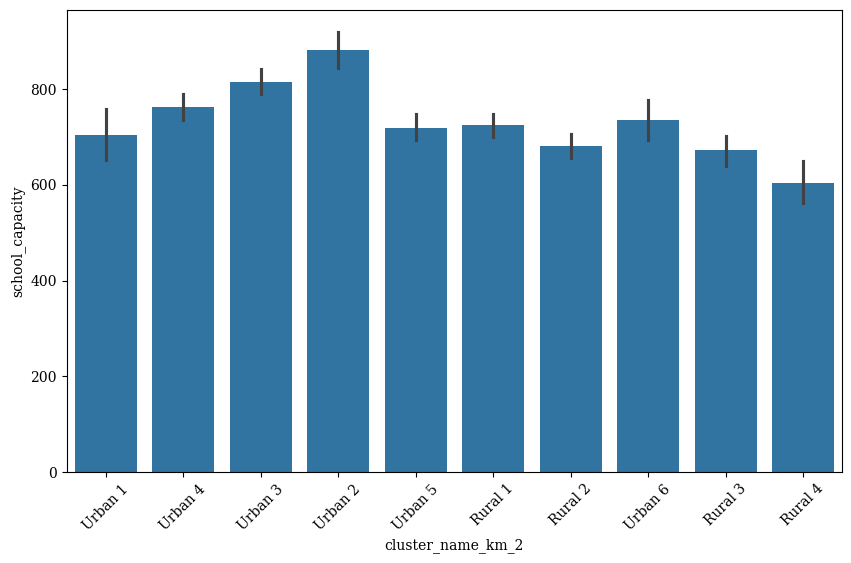

In [37]:
f, ax = plt.subplots(1, figsize=(10, 6))
sns.barplot(x='cluster_name_km_2', y='school_capacity', data=gdf, ax=ax)

# rotate y ticks
plt.xticks(rotation=45)